# Linear Regression Modeling of King County Real Estate Sale Prices


<figure>
    <img src="data/Seattle-sky.jpeg"
         align="Center"
         width="600"
         height="300">
</figure>

# Overview

 - We identified a business problem, cleaned the data, set parameters, dropped outliers, and used OLS models to infer house prices in King County, Washington.

# Business Problem

For this project, our stakeholder is a young and growing family looking to reloacte to King County, Washington. They are looking for a single family home with enough space for the family to grow. This includes looking at the more than two bedrooms, a structually safe home, and to live within a top rated school district for their kids education.

# Data Understanding

The data set used in this analysis is open-source data available directly from the county website in King County, Washington (https://kingcounty.gov/services/data.aspx). This data set covers various aspects of realestate transactions including date of sale, square footage of house and lot, bedroom, bathrooms, and condition, etc.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Data Preparation

First, we read-in the CSV file of the house data from King County, WA. This data is initially imported with 30,155 records from June 2021 to June 2022. We then prepare the data by cleaning it. This means converting some of our columns from objects to contain numerical values.

In [31]:
data=pd.read_csv('data/kc_house_data.csv')

In [32]:
#Convert Grade, Condition, Waterfront, Greenbelt, and View to numeric values.
#Convert Date to datetime

# replaces string with numerical value
data['grade'] = data['grade'].str.extract('(\d+)')
data['grade'] = pd.to_numeric(data['grade'])


# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
data.condition.replace(to_replace=condition_dict,inplace=True)


# convert waterfront into numeric boolean
waterfront_bd = {'Yes':1,'No':0,np.nan:0}
data.waterfront.replace(to_replace=waterfront_bd,inplace=True)

# convert greenbelt into numeric boolean
greenbelt_bd = {'Yes':1,'No':0,np.nan:0}
data.greenbelt.replace(to_replace=greenbelt_bd,inplace=True)


# binning view to view or no view
view = {'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'}
no_view = {'NONE'}
data['view'] = data['view'].apply(lambda x: "view" if x in view else ("no view" if x in no_view else x))


# convert dates
data.date = pd.to_datetime(data.date)

In [33]:
# convert sqft_basement to boolean-- Some houses sqft_living appears to include sqft_basement
data['basement'] = 0
for index, row in data.iterrows():
    if row['sqft_basement'] > 0:
        data.loc[index, 'basement'] = "Yes"
for index, row in data.iterrows():
    if row['sqft_basement'] == 0:
        data.loc[index, 'basement'] = "No"

## Dropping Outliers

In this section we are checking and dropping outliers for pirce, yr_built and sqft_living. After the outliers are dropped from our 'nice_houses' dataset, we are left with 27,732 homes remaining.

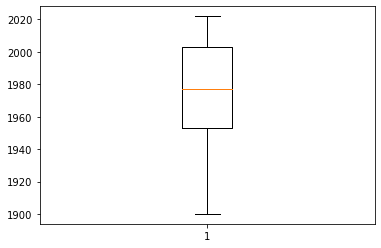

In [34]:
#Visually checking yr_built for outliers
nice_houses = data
plt.boxplot(nice_houses['yr_built'])
plt.show()

In [35]:
#droppin houses built before 1913 
med_yr_built = np.median(nice_houses['yr_built'])
up_quart_yr_built = np.percentile(nice_houses['yr_built'], 75)
low_quart_yr_built= np.percentile(nice_houses['yr_built'], 25)

iqr_yr_built = up_quart_yr_built - low_quart_yr_built
up_lim_yr_built = nice_houses['yr_built'][nice_houses['yr_built']<=up_quart_yr_built + 1.5*iqr_yr_built].max()
low_lim_yr_built = nice_houses['yr_built'][nice_houses['yr_built']>=low_quart_yr_built - 1.5*iqr_yr_built].min()
nice_houses=nice_houses.loc[(nice_houses['yr_built'] >= low_lim_yr_built) & (nice_houses['yr_built'] <= up_lim_yr_built)]

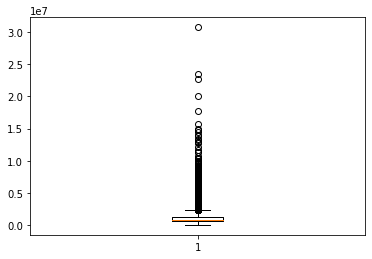

In [36]:
#Visually checking price for outliers
plt.boxplot(nice_houses['price'])
plt.show()

In [37]:
#Dropping outliers for price
med_price = np.median(nice_houses['price'])
up_quart_price = np.percentile(nice_houses['price'], 75)
low_quart_price= np.percentile(nice_houses['price'], 25)

iqr_price = up_quart_price - low_quart_price
up_lim_price= nice_houses['price'][nice_houses['price']<=up_quart_price + 1.5*iqr_price].max()
low_lim_price = nice_houses['price'][nice_houses['price']>=low_quart_price - 1.5*iqr_price].min()
nice_houses=nice_houses.loc[(nice_houses['price'] >= low_lim_price) & (nice_houses['price'] <= up_lim_price)]

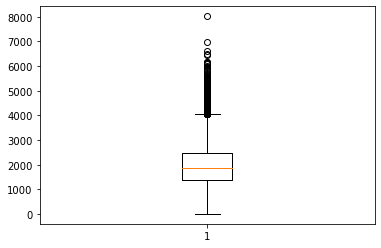

In [38]:
#Visually checking sqft_living for outliers
plt.boxplot(nice_houses['sqft_living'])
plt.show()

In [39]:
#Dropping outliers for sqft_living
med_living = np.median(nice_houses['sqft_living'])
up_quart_living  = np.percentile(nice_houses['sqft_living'], 75)
low_quart_living = np.percentile(nice_houses['sqft_living'], 25)

iqr_living  = up_quart_living  - low_quart_living 
up_lim_living = nice_houses['sqft_living'][nice_houses['sqft_living']<=up_quart_living  + 1.5*iqr_living ].max()
low_lim_living  = nice_houses['sqft_living'][nice_houses['sqft_living']>=low_quart_living  - 1.5*iqr_living ].min()
nice_houses=nice_houses.loc[(nice_houses['sqft_living'] >= low_lim_living ) & (nice_houses['sqft_living'] <= up_lim_living )]

## Stakeholder Parameters

The stakeholders we've defined is a young and growing single family. They are looking for a single family home with at least 3 bedrooms and 1 bathroom. One fo the perameter focal points is for the condition of the home to be a 3 and above. Also, the grading code of the home will be between 7 and 12. The other main perameter was selected by finding the zip codes with the top rated school districts in them. After creating and implementing these parameters, we are left with 906 records.



- Data Citation: 2022 King County ZIP Codes with the best public schools. Niche. (n.d.). Retrieved February 15, 2023, from https://www.niche.com/places-to-live/search/zip-codes-with-the-best-public-schools/c/king-county-wa/

In [40]:
# Dropping houses with grade and condition below average 
#good bones
nice_houses = data.drop(data[data.condition.isin(["1", "2"])].index)
nice_houses = data.drop(data[data.grade.isin(["13","6", "5", "4", "3", "2", "1"])].index)

In [41]:
# Dropping lat, long, heat_source, sewer_system, sqft_above and id columns.
#Dropping sqft_above bc it is too close to sqft living and sqft basement because basement is boolean 

nice_houses.drop(columns= ['lat', 'long', 'id','heat_source', 'sewer_system', 'sqft_above', 'greenbelt','waterfront', 'sqft_basement'], inplace=True)

In [42]:
# Dropping houses with less than 1 and more than 3 bathrooms
nice_houses = nice_houses.loc[(nice_houses['bathrooms'] > 1)]

# Dropping houses with less than 2 bedrooms
nice_houses = nice_houses.loc[(nice_houses['bedrooms'] >= 3)]

In [43]:
# Adding zip code column

nice_houses['zip'] = nice_houses['address'].str.extract(r'(\d{5}-?\d{0,4})')

In [44]:
# Filtering by zip codes with strong school districts 
top_school_districts = ['98004', '98005', '98007', '98008', '98039', '98052', '98074', '98033', '98006', '98053', '98034', '98075', '98029', '98011', '98040', '98028', '98072', '98059', 
                        '98155', '98177']

nice_houses = nice_houses.loc[nice_houses['zip'].isin(top_school_districts)]

In [45]:
#Grouping top school distirct zip codes together based on geo-location
redmond = {'98004', '98005', '98007', '98008', '98039', '98033', '98052'}
north_kc={'98177', '98155', '98028', '98011', '98072', '98034'}
sammamish={'98029', '98075', '98074', '98053'}
newcastle={'98040', '98006', '98059'}

#Labeling zip codes with corresponding area
nice_houses['Redmond'] = nice_houses['zip'].apply(lambda x: 1 if x in redmond else 0)
nice_houses['North KC'] = nice_houses['zip'].apply(lambda x: 1 if x in north_kc else 0)
nice_houses['Sammamish'] = nice_houses['zip'].apply(lambda x: 1 if x in sammamish else 0)
nice_houses['Newcastle'] = nice_houses['zip'].apply(lambda x: 1 if x in newcastle else 0)

#Separating zip codes into designated columns 
nice_houses['zip'] = nice_houses.apply(lambda row: 
                                       'Redmond' if row['Redmond'] == 1 
                                       else 'North KC' if row['North KC'] == 1 
                                       else 'Sammamish' if row['Sammamish'] == 1 
                                       else 'Newcastle' if row['Newcastle'] == 1 
                                       else row['zip'], axis=1)

##### Setting Budget Based On Median Data Scientist Salary in Seattle

 - The stakeholder is willing to spend 20% of their annual household income  on a 15 yr mortgage. We took a look at the average income based on their occupation and area. This enables us to define a spending budget for our stakeholders.
 
 - Data Citation: Data scientist salary in Seattle, WA. Levels.fyi. (n.d.). Retrieved February 15, 2023, from https://www.levels.fyi/t/data-scientist/locations/greater-seattle-area

In [46]:
#budget calculator 
salary=202000*2
mort_yr=15
budget=salary*0.2*mort_yr

In [47]:
# Convert price to an integer & setting budget parameter
#nice_houses['price'] = nice_houses['price'].astype(int)
nice_houses=nice_houses.loc[(nice_houses['price']<=budget)]

### Checking dataframe after parameters set

In [48]:
nice_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 29 to 30113
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          906 non-null    datetime64[ns]
 1   price         906 non-null    float64       
 2   bedrooms      906 non-null    int64         
 3   bathrooms     906 non-null    float64       
 4   sqft_living   906 non-null    int64         
 5   sqft_lot      906 non-null    int64         
 6   floors        906 non-null    float64       
 7   nuisance      906 non-null    object        
 8   view          906 non-null    object        
 9   condition     906 non-null    int64         
 10  grade         906 non-null    int64         
 11  sqft_garage   906 non-null    int64         
 12  sqft_patio    906 non-null    int64         
 13  yr_built      906 non-null    int64         
 14  yr_renovated  906 non-null    int64         
 15  address       906 non-null    object 

## Checking For Multicolliniarity

In this section we check to see if the independent variables are correlated with one another. We used a correlation matrix and color scaling to see the pairwise correlation between all of the variables. We have included 'price' as the dependent variable. None of the variables have a correlation of .7 or higher. The highest correlations in this matrix are between:
- yr_built & floors (.687)
- sqft_living & bathrooms (.598)
- sqft_living & bedrooms (.519)
- sqft_living & grade (.517)

In [49]:
#Correlation b/w x-predictors
nice_houses['avg_price'] = nice_houses['price'].mean()
nh=pd.get_dummies(nice_houses.drop(columns=['address', 'date', 'avg_price']))
nh.corr().style.background_gradient(cmap='coolwarm')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_garage,sqft_patio,yr_built,yr_renovated,Redmond,North KC,Sammamish,Newcastle,nuisance_NO,nuisance_YES,view_no view,view_view,basement_No,basement_Yes,zip_Newcastle,zip_North KC,zip_Redmond,zip_Sammamish
price,1.000000,0.150696,0.135674,0.206432,-0.016961,0.107017,0.117054,0.232673,0.113183,0.082960,0.056117,-0.016327,0.156438,-0.082635,0.067960,-0.098793,0.057643,-0.057643,-0.026976,0.026976,0.031150,-0.031150,-0.098793,-0.082635,0.156438,0.067960
bedrooms,0.150696,1.000000,0.413564,0.519384,-0.010571,0.058293,0.005030,0.102298,-0.042038,0.036160,0.023521,0.015717,-0.051326,0.055284,-0.140471,0.099922,0.004387,-0.004387,-0.016210,0.016210,-0.129556,0.129556,0.099922,0.055284,-0.051326,-0.140471
bathrooms,0.135674,0.413564,1.000000,0.598866,-0.040455,0.370813,-0.094361,0.344345,0.175690,0.153109,0.409054,0.025771,-0.182420,0.017070,0.054514,0.091120,0.067312,-0.067312,-0.053646,0.053646,-0.151711,0.151711,0.091120,0.017070,-0.182420,0.054514
sqft_living,0.206432,0.519384,0.598866,1.000000,0.091074,0.304066,-0.073368,0.517263,0.154963,0.238150,0.261701,-0.012468,-0.164032,0.040166,-0.065793,0.150342,0.068298,-0.068298,-0.121131,0.121131,-0.174117,0.174117,0.150342,0.040166,-0.164032,-0.065793
sqft_lot,-0.016961,-0.010571,-0.040455,0.091074,1.000000,-0.160367,0.034927,0.023936,0.007615,0.128391,-0.222534,-0.001414,-0.070582,0.003217,0.187510,-0.099873,-0.067381,0.067381,-0.055854,0.055854,-0.105241,0.105241,-0.099873,0.003217,-0.070582,0.187510
floors,0.107017,0.058293,0.370813,0.304066,-0.160367,1.000000,-0.269932,0.381782,0.151792,-0.008315,0.687679,-0.034952,-0.175728,-0.235538,0.230207,0.217695,0.088461,-0.088461,0.020131,-0.020131,0.435511,-0.435511,0.217695,-0.235538,-0.175728,0.230207
condition,0.117054,0.005030,-0.094361,-0.073368,0.034927,-0.269932,1.000000,-0.122841,-0.100922,0.071278,-0.335150,-0.105973,0.087353,0.009673,-0.111106,0.007594,-0.000911,0.000911,-0.032169,0.032169,-0.067897,0.067897,0.007594,0.009673,0.087353,-0.111106
grade,0.232673,0.102298,0.344345,0.517263,0.023936,0.381782,-0.122841,1.000000,0.296070,0.149456,0.346856,-0.010506,-0.063247,-0.098989,0.105216,0.075386,0.035228,-0.035228,-0.123880,0.123880,0.108882,-0.108882,0.075386,-0.098989,-0.063247,0.105216
sqft_garage,0.113183,-0.042038,0.175690,0.154963,0.007615,0.151792,-0.100922,0.296070,1.000000,0.061203,0.323528,-0.034277,-0.033437,-0.113462,0.050601,0.111536,0.168155,-0.168155,0.025175,-0.025175,0.017567,-0.017567,0.111536,-0.113462,-0.033437,0.050601
sqft_patio,0.082960,0.036160,0.153109,0.238150,0.128391,-0.008315,0.071278,0.149456,0.061203,1.000000,-0.054763,0.064843,-0.022748,0.016513,0.051750,-0.042028,0.047920,-0.047920,-0.180109,0.180109,-0.166800,0.166800,-0.042028,0.016513,-0.022748,0.051750


## Checking for Linearity  

In [50]:
#Checking numerical columns for correlation b/w x and y
y_linear=nice_houses['price']
X_linear=nice_houses.drop(columns=['price', 'avg_price'])
dp = pd.concat([X_linear,y_linear],axis=1)
dp.corr().price.sort_values(ascending=False)

price           1.000000
grade           0.232673
sqft_living     0.206432
Redmond         0.156438
bedrooms        0.150696
bathrooms       0.135674
condition       0.117054
sqft_garage     0.113183
floors          0.107017
sqft_patio      0.082960
Sammamish       0.067960
yr_built        0.056117
yr_renovated   -0.016327
sqft_lot       -0.016961
North KC       -0.082635
Newcastle      -0.098793
Name: price, dtype: float64

In [51]:
#Check correlation for non-numerical columns
y_1 = nice_houses['price']
x_1 = pd.get_dummies(nice_houses[['nuisance','view', 'basement','zip']])
model = sm.OLS(y_1,sm.add_constant(x_1)).fit()

dp_1 = pd.concat([x_1,y_1],axis=1)
dp_1.corr().price.sort_values(ascending=False)

price            1.000000
zip_Redmond      0.156438
zip_Sammamish    0.067960
nuisance_NO      0.057643
basement_No      0.031150
view_view        0.026976
view_no view    -0.026976
basement_Yes    -0.031150
nuisance_YES    -0.057643
zip_North KC    -0.082635
zip_Newcastle   -0.098793
Name: price, dtype: float64

# Models

## Baseline Model-DummyRegressor

In [52]:
# Baseline Model
nice_houses['avg_price'] = nice_houses['price'].mean()
X_base = nice_houses['avg_price']
y_base = nice_houses['price']
baseline_model=sm.OLS(y_base, sm.add_constant(X_base)).fit()
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 17 Feb 2023   Prob (F-statistic):                nan
Time:                        15:16:25   Log-Likelihood:                -12407.
No. Observations:                 906   AIC:                         2.482e+04
Df Residuals:                     905   BIC:                         2.482e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_price      1.0000      0.008    130.234      0.000       0.985       1.015
==============================================================================
Omnibus:                      185.773   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              363.454
Skew:                          -1.184   Prob(JB):                     1.19e-79
Kurtosis:                       5.006   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
nice_houses['avg_price']#sanity check

29       928393.113687
192      928393.113687
208      928393.113687
307      928393.113687
337      928393.113687
             ...      
30056    928393.113687
30096    928393.113687
30108    928393.113687
30110    928393.113687
30113    928393.113687
Name: avg_price, Length: 906, dtype: float64

## First Simple Model

In [54]:
y_fsm = nice_houses['price']
x_fsm = nice_houses[['sqft_living']]
fsm_data = sm.OLS(y_fsm, sm.add_constant(x_fsm))
fsm_results = fsm_data.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     40.24
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           3.55e-10
Time:                        15:16:25   Log-Likelihood:                -12388.
No. Observations:                 906   AIC:                         2.478e+04
Df Residuals:                     904   BIC:                         2.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.732e+05   2.54e+04     30.401      0.000    7.23e+05    8.23e+05
sqft_living    77.3186     12.189      6.343      0.000      53.397     101.241
==============================================================================
Omnibus:                      229.233   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.033
Skew:                          -1.325   Prob(JB):                    4.50e-124
Kurtosis:                       5.833   Cond. No.                     7.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Results -->

### The Assumptions of Linear Regression
>We have checked for linearity before Models

>We have checked for multicollinearity before Models

In [55]:
#LinearRegression for y-predictions
lr = LinearRegression()
lr.fit(x_fsm, y_fsm)
y_pred_fsm = lr.predict(x_fsm)

##### Checking for Normality

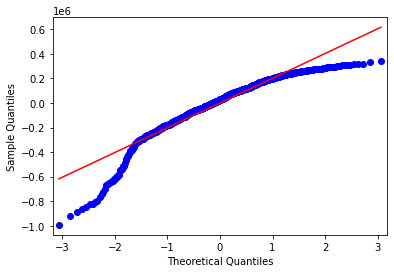

In [56]:
y_true = nice_houses['price']
y_pred = y_pred_fsm
fsm_residual = y_true - y_pred
sm.qqplot(fsm_residual, line = 'r');

>The residuals seem to have a normal distribution

In [57]:
#Mean Squared Error
y_true = nice_houses['price']
y_pred = y_pred_fsm
rmse_fsm=(mean_squared_error(y_true,y_pred))**0.5
rmse_fsm

209833.53357209646

>MSE tells us that our FSM is $209,833 off while predicting the price

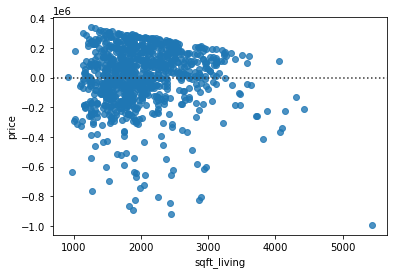

In [58]:
#Checking if residuals are homoskedastic
sns.residplot(x=x_fsm, y=y_fsm)
plt.show()

>This assumption of linear regression is broken because our residuals are heteroscedastic and biased

<AxesSubplot:ylabel='price'>

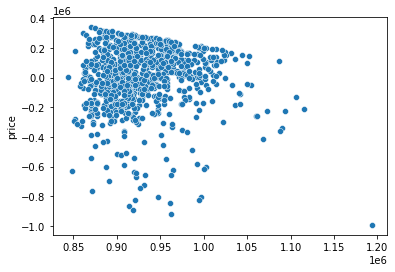

In [59]:
#Checking to see if residuals are correlated
sns.scatterplot(x=y_pred, y=fsm_residual)

>No trends in error terms

## Model 2 - Redmond

In [60]:
y_model2 = nice_houses['price']
x_model2 = pd.get_dummies(nice_houses[['bedrooms', 'condition','Redmond', 'grade', 'bathrooms']])
model2_data = sm.OLS(y_model2, sm.add_constant(x_model2))
model2_results = model2_data.fit()
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     24.79
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           1.90e-23
Time:                        15:16:57   Log-Likelihood:                -12349.
No. Observations:                 906   AIC:                         2.471e+04
Df Residuals:                     900   BIC:                         2.474e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.816e+04   9.09e+04      0.420      0.675    -1.4e+05    2.17e+05
bedrooms    3.448e+04   1.05e+04      3.284      0.001    1.39e+04    5.51e+04
condition   4.217e+04   9916.694      4.252      0.000    2.27e+04    6.16e+04
Redmond     9.937e+04   1.81e+04      5.488      0.000    6.38e+04    1.35e+05
grade       7.287e+04   1.06e+04      6.871      0.000    5.21e+04    9.37e+04
bathrooms   2.178e+04   1.48e+04      1.470      0.142   -7304.989    5.09e+04
==============================================================================
Omnibus:                      235.399   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.310
Skew:                          -1.325   Prob(JB):                    1.35e-137
Kurtosis:                       6.110   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The Assumptions of Linear Regression
>We have checked for linearity before Models

>We have checked for multicollinearity before Models

In [61]:
#LinearRegression for y-predictions
lr = LinearRegression()
lr.fit(x_model2, y_model2)
y_pred_model2 = lr.predict(x_model2)

##### Checking for Normality

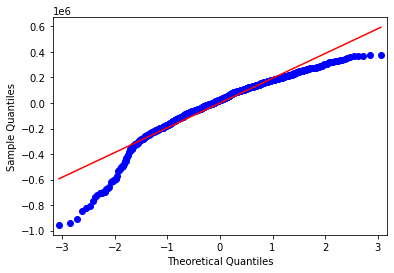

In [62]:
y_true2 = nice_houses['price']
y_pred2 = y_pred_model2
model2_residual = y_true2 - y_pred2
sm.qqplot(model2_residual, line = 'r');

>The residuals seem to have a normal distribution

In [63]:
#Mean Squared Error
y_true2 = nice_houses['price']
y_pred2 = y_pred_model2
rmse_model2=(mean_squared_error(y_true2,y_pred2))**0.5
rmse_model2

201055.84543174016

>MSE tells us that our FSM is $201,055 off while predicting the price

/Users/vincentamadio3/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


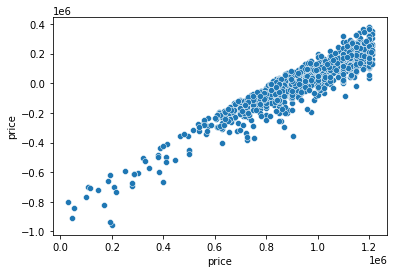

In [64]:
#Checking if residuals are homoskedastic
sns.scatterplot (y_model2, model2_residual);

>The residuals are homoskedastic and biased

<AxesSubplot:ylabel='price'>

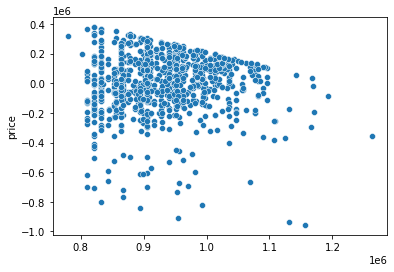

In [65]:
#Checking to see if residuals are correlated
sns.scatterplot(x=y_pred2, y=model2_residual)

>No trends in error terms

## Model 3 - North King County

In [66]:
y_model3 = nice_houses['price']
x_model3 = pd.get_dummies(nice_houses[['North KC','bedrooms','bathrooms', 'condition', 'grade']])
model3_data = sm.OLS(y_model3, sm.add_constant(x_model3))
model3_results = model3_data.fit()
model3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     19.18
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           3.58e-18
Time:                        15:17:07   Log-Likelihood:                -12362.
No. Observations:                 906   AIC:                         2.474e+04
Df Residuals:                     900   BIC:                         2.476e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.052e+04   9.28e+04      0.976      0.329   -9.15e+04    2.73e+05
North KC   -3.027e+04    1.4e+04     -2.163      0.031   -5.77e+04   -2800.197
bedrooms    3.696e+04   1.07e+04      3.469      0.001    1.61e+04    5.79e+04
bathrooms   9500.7938   1.48e+04      0.641      0.522   -1.96e+04    3.86e+04
condition   4.599e+04      1e+04      4.585      0.000    2.63e+04    6.57e+04
grade       7.076e+04   1.08e+04      6.540      0.000    4.95e+04     9.2e+04
==============================================================================
Omnibus:                      209.100   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.824
Skew:                          -1.238   Prob(JB):                    5.27e-106
Kurtosis:                       5.590   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results-->

### The Assumptions of Linear Regression
>We have checked for linearity before Models

>We have checked for multicollinearity before Models

In [67]:
#LinearRegression for y-predictions
lr = LinearRegression()
lr.fit(x_model3, y_model3)
y_pred_model3 = lr.predict(x_model3)

##### Checking for Normality

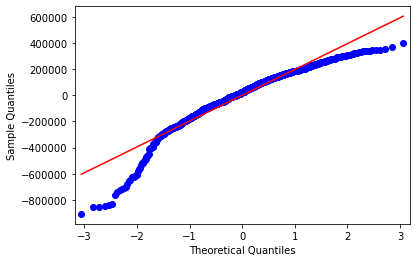

In [68]:
y_true3 = nice_houses['price']
y_pred3 = y_pred_model3
model3_residual = y_true3 - y_pred3
sm.qqplot(model3_residual, line = 'r');

>The residuals seem to have a normal distribution

In [69]:
#Mean Squared Error
y_true3 = nice_houses['price']
y_pred3 = y_pred_model3
rmse_model3=(mean_squared_error(y_true3,y_pred3))**0.5
rmse_model3

203863.58270089029

>MSE tells us that our FSM is $203,863 off while predicting the price

/Users/vincentamadio3/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


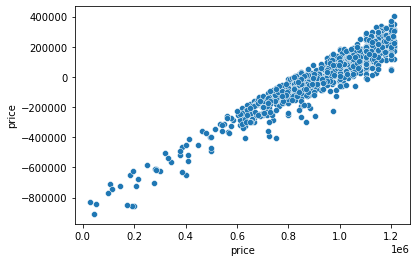

In [70]:
#Checking if residuals are homoskedastic
sns.scatterplot (y_model3, model3_residual);

>The residuals are homoskedastic and biased

<AxesSubplot:ylabel='price'>

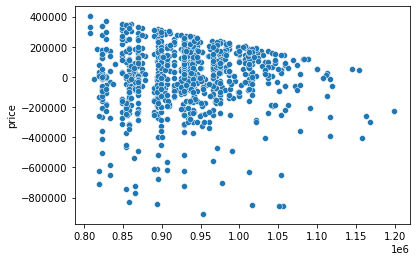

In [71]:
#Checking to see if residuals are correlated
sns.scatterplot(x=y_pred3, y=model3_residual)

>There seems to be a trend in error terms-Autocorrelation

## Model 4 - Newcastle

In [72]:
y_model4 = nice_houses['price']
x_model4 = pd.get_dummies(nice_houses[['Newcastle', 'bedrooms','bathrooms', 'condition', 'grade']])
model4_data = sm.OLS(y_model4, sm.add_constant(x_model4))
model4_results = model4_data.fit()
model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     22.03
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           7.20e-21
Time:                        15:17:24   Log-Likelihood:                -12355.
No. Observations:                 906   AIC:                         2.472e+04
Df Residuals:                     900   BIC:                         2.475e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.597e+04   9.15e+04      0.502      0.615   -1.34e+05    2.26e+05
Newcastle  -6.444e+04   1.54e+04     -4.198      0.000   -9.46e+04   -3.43e+04
bedrooms    3.897e+04   1.06e+04      3.679      0.000    1.82e+04    5.98e+04
bathrooms   1.076e+04   1.47e+04      0.731      0.465   -1.81e+04    3.97e+04
condition   4.677e+04   9960.515      4.696      0.000    2.72e+04    6.63e+04
grade       7.564e+04   1.07e+04      7.074      0.000    5.47e+04    9.66e+04
==============================================================================
Omnibus:                      225.303   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.708
Skew:                          -1.282   Prob(JB):                    1.78e-127
Kurtosis:                       5.982   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results-->

### The Assumptions of Linear Regression
>We have checked for linearity before Models

>We have checked for multicollinearity before Models

In [73]:
#LinearRegression for y-predictions
lr = LinearRegression()
lr.fit(x_model4, y_model4)
y_pred_model4 = lr.predict(x_model4)

##### Checking for Normality

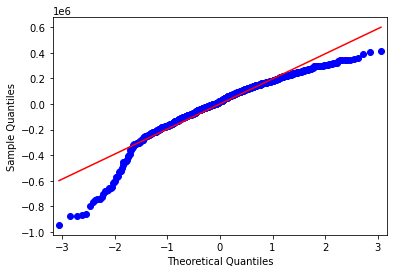

In [74]:
y_true4 = nice_houses['price']
y_pred4 = y_pred_model4
model4_residual = y_true4 - y_pred4
sm.qqplot(model4_residual, line = 'r');

>The residuals seem to have a normal distribution

In [75]:
#Mean Squared Error
y_true4 = nice_houses['price']
y_pred4 = y_pred_model4
rmse_model4=(mean_squared_error(y_true4,y_pred4))**0.5
rmse_model4

202420.54144755128

>MSE tells us that our FSM is $204,420 off while predicting the price

/Users/vincentamadio3/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


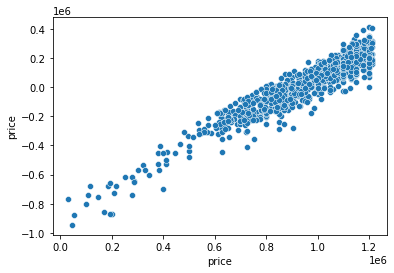

In [76]:
#Checking if residuals are homoskedastic
sns.scatterplot (y_model4, model4_residual);

>The residuals are homoskedastic and biased

<AxesSubplot:ylabel='price'>

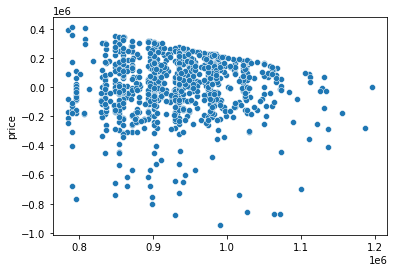

In [77]:
#Checking to see if residuals are correlated
sns.scatterplot(x=y_pred4, y=model4_residual)

>There seems to be a trend in error terms-Autocorrelation

## Model 5 - Sammamish

In [78]:
#zip sammamish
y_model5 = nice_houses['price']
x_model5 = pd.get_dummies(nice_houses[['Sammamish', 'bedrooms', 'bathrooms', 'condition', 'grade']])
model5_data = sm.OLS(y_model5, sm.add_constant(x_model5))
model5_results = model5_data.fit()
model5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     19.47
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           1.94e-18
Time:                        15:17:36   Log-Likelihood:                -12361.
No. Observations:                 906   AIC:                         2.473e+04
Df Residuals:                     900   BIC:                         2.476e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.635e+04    9.2e+04      0.612      0.541   -1.24e+05    2.37e+05
Sammamish   4.598e+04   1.88e+04      2.439      0.015    8987.192     8.3e+04
bedrooms     4.04e+04   1.08e+04      3.742      0.000    1.92e+04    6.16e+04
bathrooms   5473.7020   1.49e+04      0.368      0.713   -2.37e+04    3.47e+04
condition   4.829e+04   1.01e+04      4.798      0.000    2.85e+04     6.8e+04
grade        7.13e+04   1.08e+04      6.615      0.000    5.01e+04    9.25e+04
==============================================================================
Omnibus:                      207.425   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.722
Skew:                          -1.223   Prob(JB):                    2.04e-106
Kurtosis:                       5.629   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results-->

### The Assumptions of Linear Regression
>We have checked for linearity before Models

>We have checked for multicollinearity before Models

In [79]:
#LinearRegression for y-predictions
lr = LinearRegression()
lr.fit(x_model5, y_model5)
y_pred_model5 = lr.predict(x_model5)

##### Checking for Normality

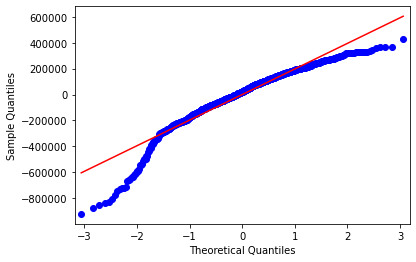

In [80]:
y_true5 = nice_houses['price']
y_pred5 = y_pred_model5
model5_residual = y_true5 - y_pred5
sm.qqplot(model5_residual, line = 'r');

>The residuals seem to have a normal distribution

In [81]:
#Mean Squared Error
y_true5 = nice_houses['price']
y_pred5 = y_pred_model5
rmse_model5=(mean_squared_error(y_true5,y_pred5))**0.5
rmse_model5

203720.2054725746

>MSE tells us that our FSM is $203,863 off while predicting the price

/Users/vincentamadio3/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


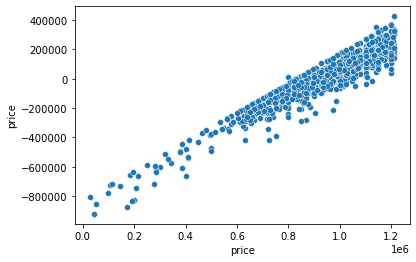

In [82]:
#Checking if residuals are homoskedastic
sns.scatterplot (y_model5, model5_residual);

>The residuals are homoskedastic and biased

<AxesSubplot:ylabel='price'>

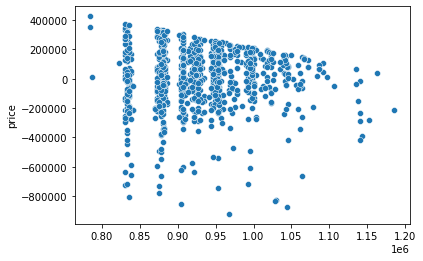

In [83]:
#Checking to see if residuals are correlated
sns.scatterplot(x=y_pred5, y=model5_residual)

>There seems to be a trend in error terms-Autocorrelation

# Evaluation

### Average Price in King County vs Average Price in Top Areas

<figure>
    <img src="data/avgprice.png"
         align="Center"
         width="600"
         height="300">
</figure>

- The graph shows that the average price of houses in Redmond and Sammamish are above the King County average of $928k. Meanwhile, the average price of houses in North King County and Newcastle are below the average for the county.

### Price of One Bathroom in Top Areas

<figure>
    <img src="data/bathroom.png"
         align="Center"
         width="600"
         height="300">
</figure>

- The price of an additional bathroom in Redmond is four times that of Newcastle.

<figure>
    <img src="data/grade.png"
         align="Center"
         width="600"
         height="300">
</figure>

- We have found that there is minimal variance in the price of grade, condition, and the number of bedrooms when comparing Redmond, Sammamish, North King County, and Newcastle.

# Conclusion

For the purposes for our stakeholder and the business problem they provided, we recommend that they focus on areas with the best school districts: Redmond, Sammamish, North King County, and Newcastle. They should keep in mind that the average price of houses in Redmond and Sammamish are higher than the county average. Furthermore, they should consider adding an extra bathroom. When it comes to grade, condition, and the number of bedrooms, there is minimal variance in price between these features in these four areas. Since we are only looking at houses with a grade 7 to 10, and that are in good condition, these variables should not weigh heavily in their decision making.